# Bootcamp-4

# 1. Quantum Walks

* Discrete-time QW
* Continuous-time QW

A graph $\mathcal{G}$ : with $\mathcal{V}$ vertices and $\mathcal{E}$ edges

* $|j \rangle$, $|k\rangle$ denote a vertex 
* **Classiq** : *QNum* - allows to store quantum states as a number
* Only Connected vertices

Two operators $\mathcal{C}, \mathcal{S}$ will operate on the states

$$\mathcal{C} := \sum\limits_{j \in V} |j \rangle \langle j| \otimes (2|\partial_j \rangle \langle \partial_j| - I)      \quad   \quad
  |\partial_j \rangle := \frac{1}{\sqrt{deg(j)}} \sum\limits_{k:(j, k) \in \mathcal{E}} |k\rangle   $$ 

Assume : $\mathit{U_j |0\rangle = |\partial_j\rangle} $ 
<br>
$\implies$ $$  2|\partial_j \rangle \langle \partial_j| - I = U_j(2|0 \rangle \langle 0| - I)U_j^\dagger $$
<br>
$$ |2|0 \rangle \langle 0| - I)|x \rangle  = (-1)^{x \neq 0}|x \rangle$$ is the phase-kickback operator

$$ \mathcal{S} := \sum\limits_{(j, k) \in \mathcal{E}} |j, k\rangle \langle k, j | \quad$$, all the edges of the graph

# 2. Class Example 

### Explanation
The algorithm involves creating a superposition of vertices, applying a diffusion operator (W operator) to spread the amplitude across neighboring vertices, and then applying a coin flip operator (S operator) to determine if the walker moves to a neighbor.

* prepare_minus: Prepares the minus state for the auxiliary qubit to be used during phase-kickback
* diffuzer_oracle: Implements the oracle for the diffuser. 
* zero_diffuzer: Creates an auxiliary qubit, prepares it in the minus state, and applies the diffuzer oracle.

* C_iteration: Calculates the probability distribution for moving to neighboring vertices. As described in the class, it can't be coded on Qmod. Also, applies a controlled operation to update the adjacent vertices based on the calculated probabilities.
* C_operator: Iterates over all possible vertex states and applies the C_iteration for each state.
* edge_oracle: Checks if the current vertex and its adjacent vertex form an edge in the graph. Will need to change this for the case of a different graph(16 nodes) 
* bitwise_swap: Swaps the values of two quantum arrays.
* S_operator: Checks if the current state represents an edge. If so, swaps the vertex and adjacent vertex.

The example that we have done in the class and this homework is an example of quantum walk on an undirected graph. 

With the above description of used functions, the key steps can be summed up as follows:

Initialization: Create a superposition of all possible vertex states.
Diffusion: Apply the W operator to spread the amplitude to neighboring vertices.
Random choice: Apply the S operator to determine if the walker moves to a neighbor based on the edge information.
The C_operator amplifies the amplitude of the current vertex and its neighbors. The S_operator acts as the coin flip operation, deciding whether to move to a neighbor based on the edge information.

# 3. My Code
Design the quantum walk operator for the case of a line with 16 nodes:
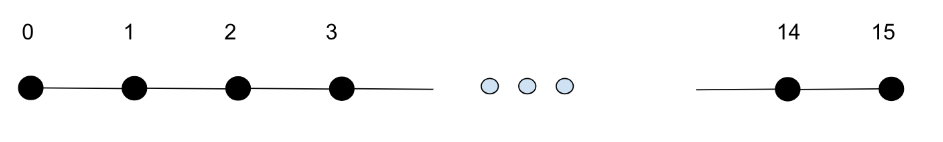

The code takes 2 inputs : 'size', and 'closed'. chain_len = 2**size, can take any value greater than 2(at least 1 edge is present). closed can take boolean values of either True or False.

* The varible 'closed' is to enforce the Periodic Boundary Condition, which is quite common and useful in physical systems.
* When closed = True, the chain is treated like a ring, i.e. the probability to jump to node 0 from and to node (chain_len - 1), and vice-versa, is 0.5 as well.

In [1]:
from classiq import *

In [2]:
size = 4
chain_len = 2**size    # This is the variable for the length of 1-D chain. Instead of 16, it could be anything

In [3]:
@qfunc
def prepare_minus(x: QBit):
    X(x)
    H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
    aux ^= (x!=0)


@qfunc
def zero_diffuzer(x: QNum):    # Phase-kickback
    aux = QNum('aux')
    allocate(1, aux)
    within_apply(compute = lambda: prepare_minus(aux),
              action = lambda: diffuzer_oracle)


def C_iteration(i:int, vertices: QNum, adjacent_vertices:QNum):
    prob = [0 for _ in range(chain_len)]
    # prob = [0]*num_nodes
    if closed :
        prob[(i+1) % chain_len] = 0.5
        prob[(i-1) % chain_len] = 0.5

    else : 
        if i == 0 :
            prob[1] = 1.0
            
        elif i == chain_len - 1 :
            prob[chain_len - 2] = 1.0

        else :
            prob[i+1] = 0.5
            prob[i-1] = 0.5

    # if i == 0 :
    #     prob[1] = 1.0
        
    # elif i == chain_len - 1 :
    #     prob[chain_len - 2] = 1.0

    # else :
    #     prob[i+1] = 0.5
    #     prob[i-1] = 0.5
    
    print(f'State={i}, prob vec = {prob}')
    
    control(ctrl = vertices == i,
            operand = lambda: within_apply(
                compute = lambda: inplace_prepare_state(probabilities = prob, bound = 0.01, target = adjacent_vertices),
                action = lambda: zero_diffuzer(adjacent_vertices)))


@qfunc 
def C_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(chain_len):
        C_iteration(i, vertices, adjacent_vertices)


@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    
    if closed :
        try : 
            index = chain_len - 1
            res |= ( ( (vertices != adjacent_vertices) & ((vertices - adjacent_vertices) == index) ) | ( ( (vertices - adjacent_vertices) == 1) | ((vertices - adjacent_vertices) == -1) ) )

        except : 
            print(f"Can't simulate for a closed ring with {chain_len} nodes. Proceeding with open chain")

    else :
        res |= (((vertices - adjacent_vertices) == 1) | ((vertices - adjacent_vertices) == -1))

# @qfunc
# def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
#     res |= (((vertices - adjacent_vertices) == 1) | ((vertices - adjacent_vertices) == -1))

@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
    repeat(count = x.len, iteration = lambda i: SWAP(x[i], y[i]))
  

@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res, vertices, adjacent_vertices)
    control(ctrl = res == 1,
        operand = lambda: bitwise_swap(vertices,adjacent_vertices))

In [4]:
@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

    # min_qubits = np.ceil(np.log2(chain_len))
    allocate(size, vertices)
    hadamard_transform(vertices)
    allocate(size, adjacent_vertices)
    
    C_operator(vertices, adjacent_vertices)
    S_operator(vertices,adjacent_vertices)

In [5]:
closed = True    # Periodic boundary condition; if the chain is closed
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

State=0, prob vec = [0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5]
State=1, prob vec = [0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec = [0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec = [0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec = [0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec = [0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec = [0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec = [0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec = [0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec = [0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec = [0, 0, 0, 0, 0, 0, 0, 0, 0,

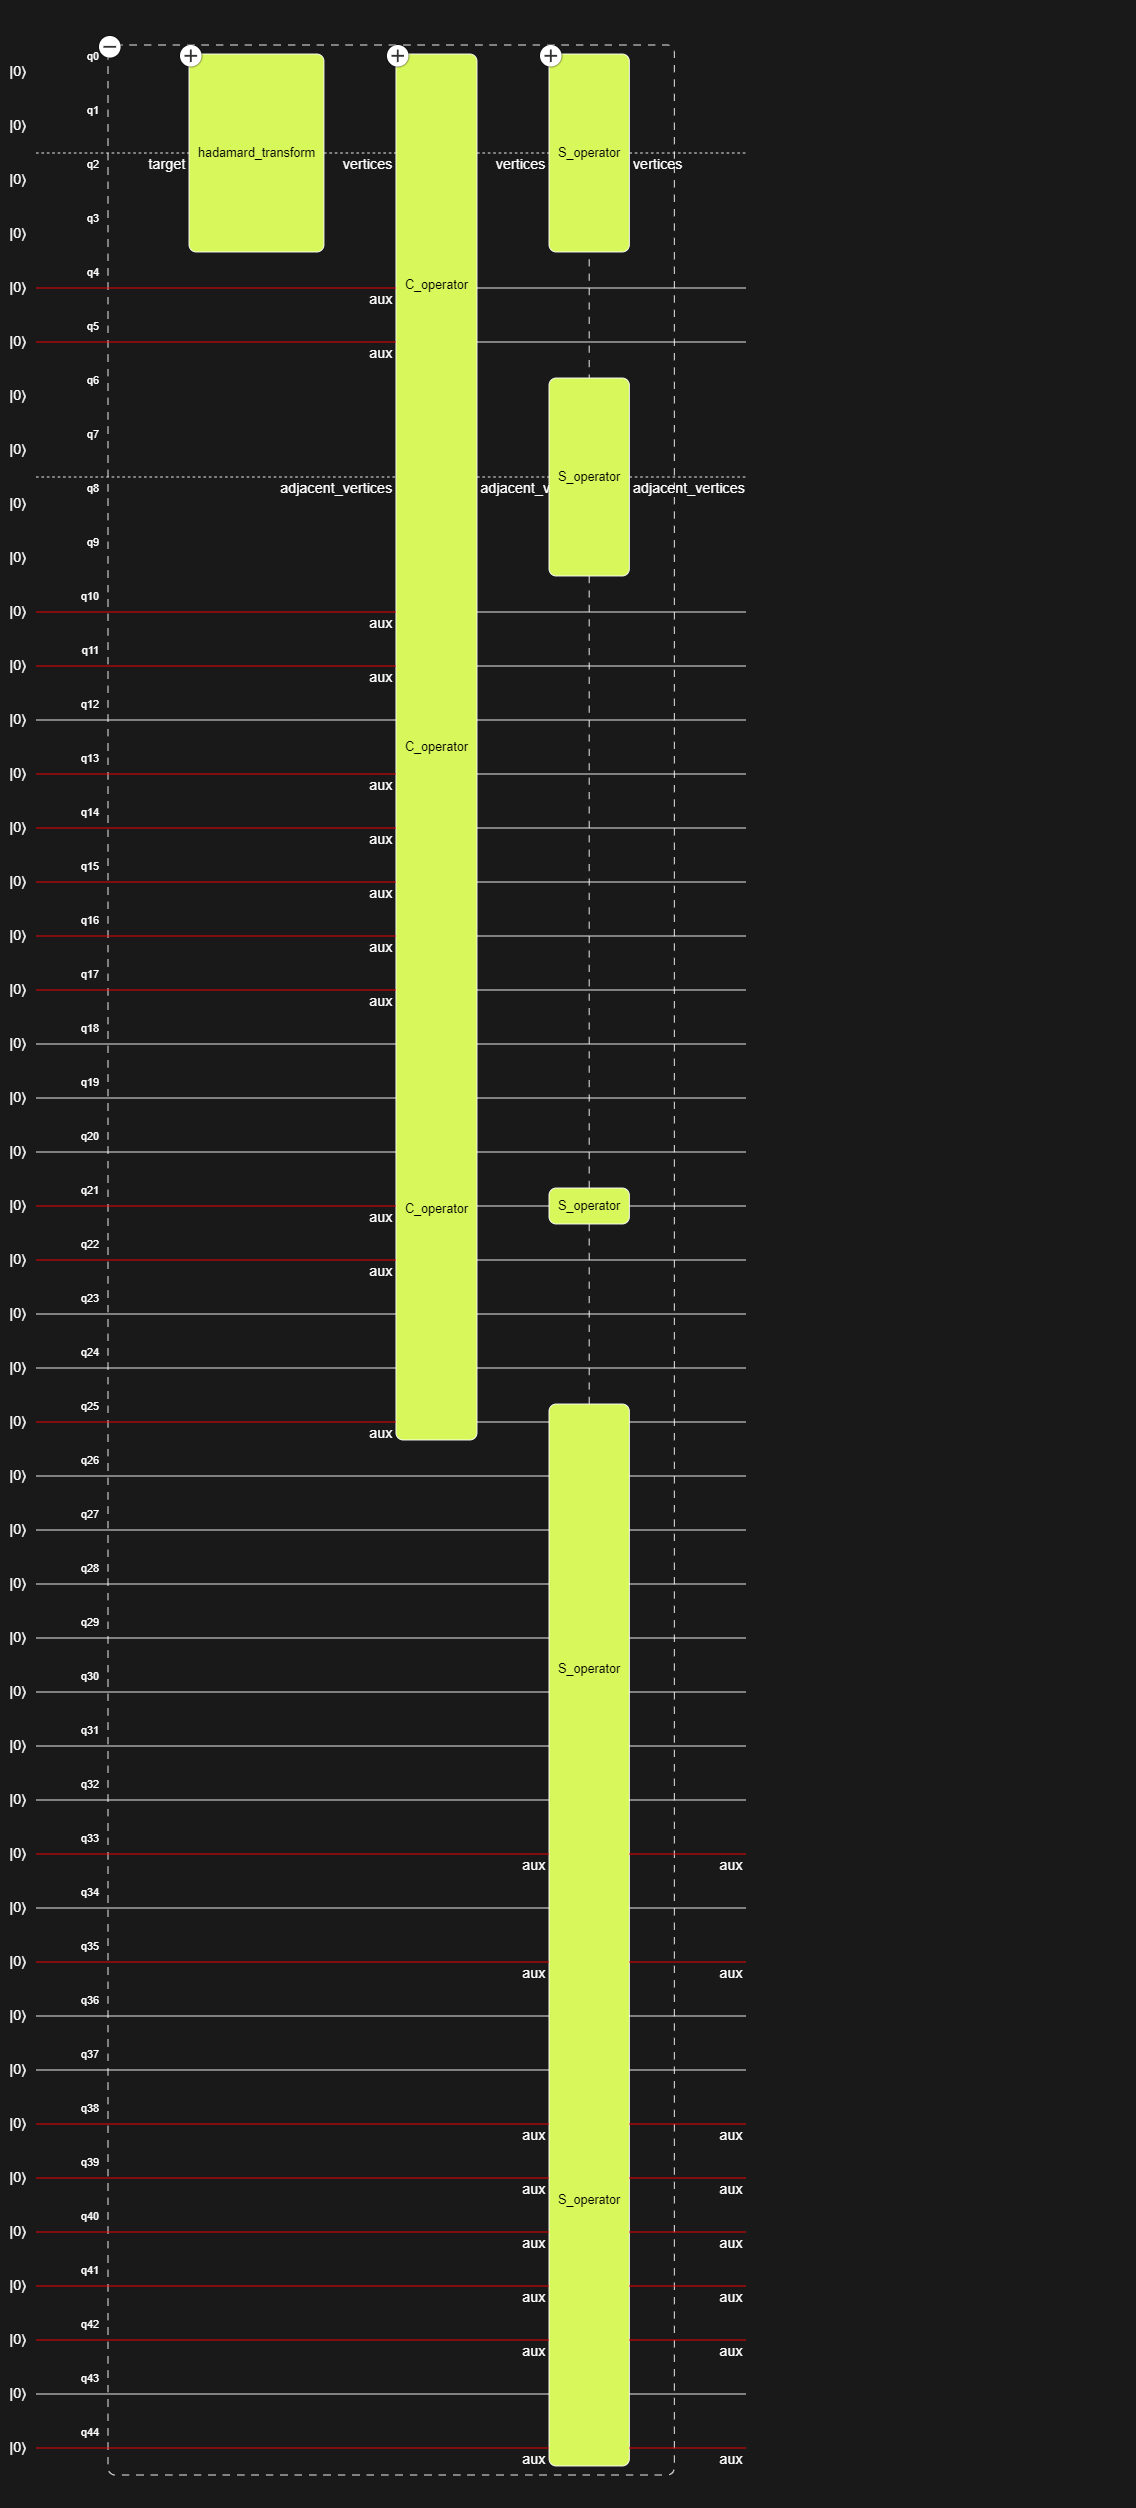

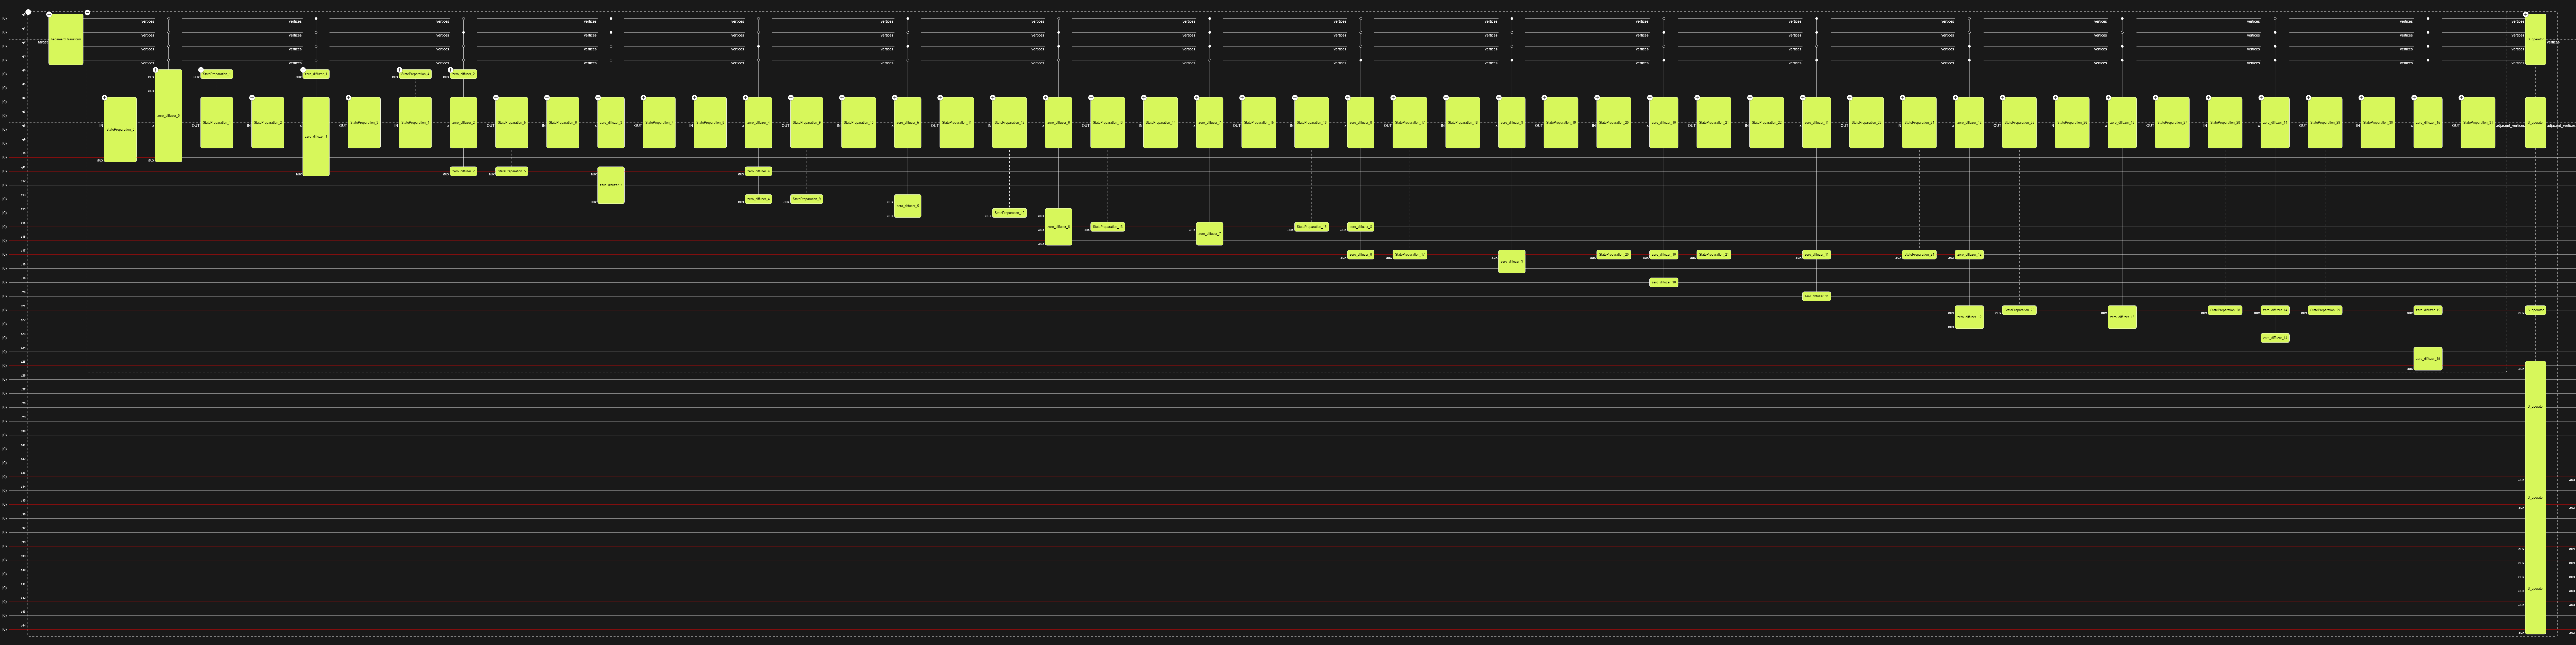
The difference can be seen in the expansion of C_operator(3rd gate) for different values of 'closed'

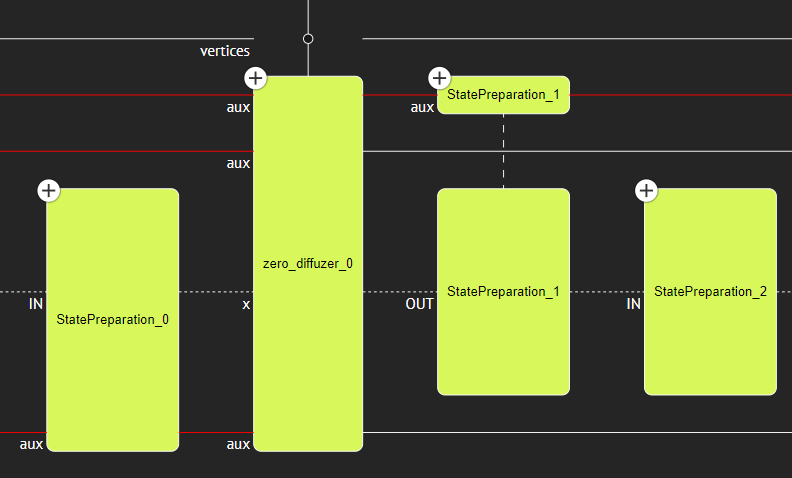

In [6]:
closed = False    # Periodic boundary condition; if the chain is closed
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

State=0, prob vec = [0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec = [0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec = [0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec = [0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec = [0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec = [0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec = [0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec = [0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec = [0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec = [0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0

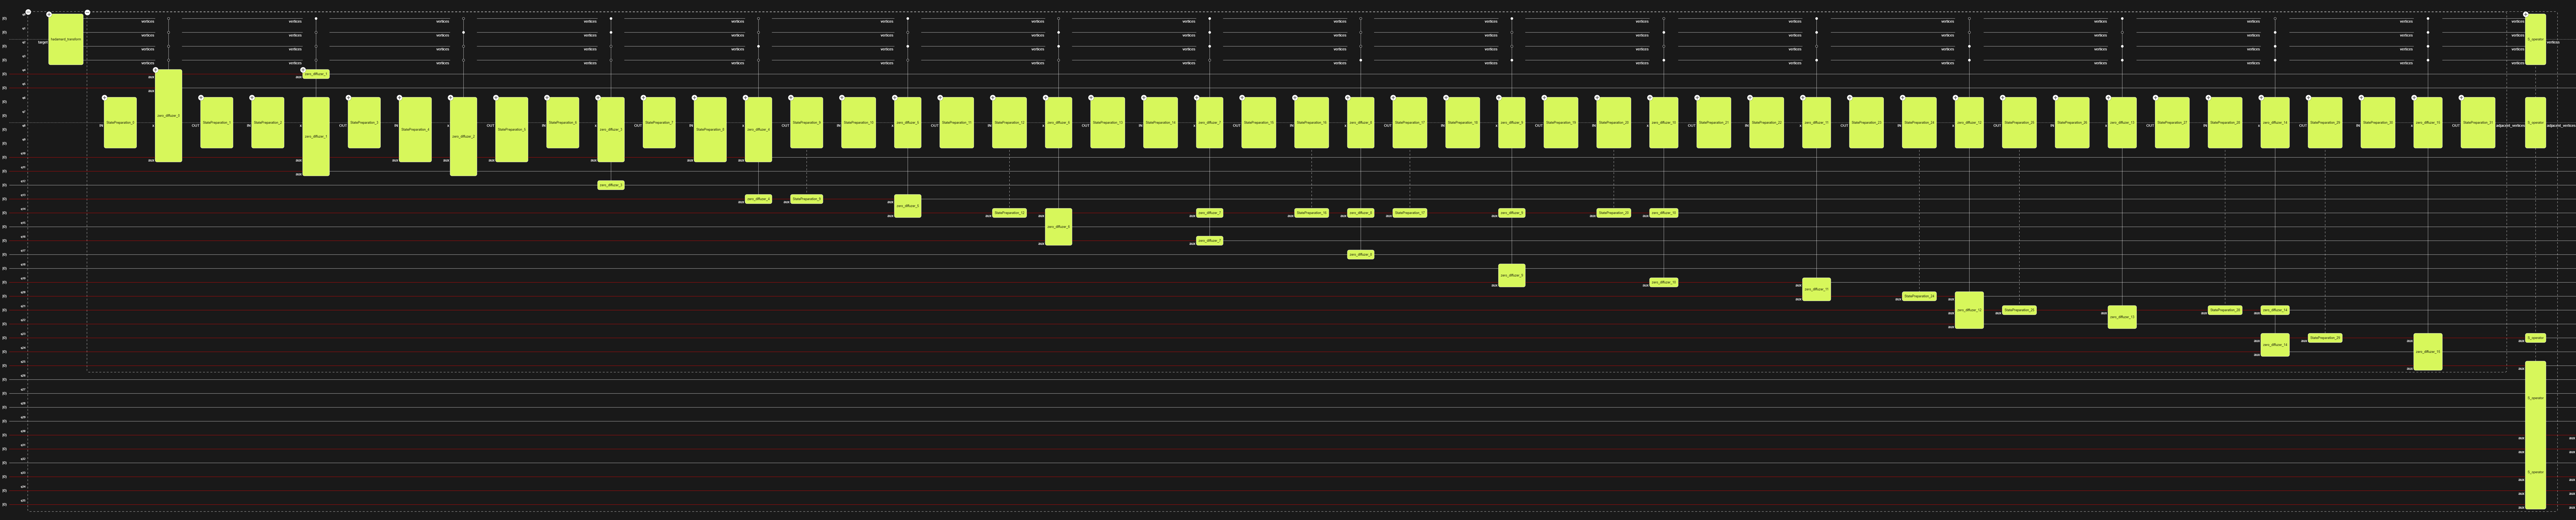

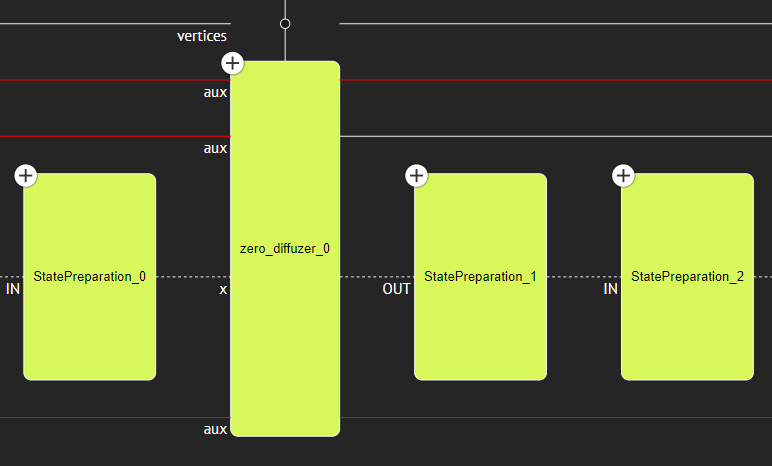